In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from keras import layers
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [193]:
df = pd.read_csv('fight_with_stats_precomp.csv')
df_fighters = pd.read_csv('fighter_total_stats.csv')

In [194]:
df = df[(df['fightNo_fighter']>=3) & (df['fightNo_opponent']>=3) & (df['Women_fight']==0)]

In [195]:
df = df.fillna(0)


In [196]:
df.head()

,EVENT,BOUT,FIGHTER,OPPONENT,METHOD,Win,Women_fight,ROUND,HEIGHT_diff,REACH_diff,...,BODY_landed_opponent,BODY_attemps_opponent,LEG_landed_opponent,LEG_attemps_opponent,DISTANCE_landed_opponent,DISTANCE_attemps_opponent,CLINCH_landed_opponent,CLINCH_attemps_opponent,GROUND_landed_opponent,GROUND_attemps_opponent
24,UFC 2: No Way Out,Royce Gracie vs. Patrick Smith,Patrick Smith,Royce Gracie,KO/TKO - ground,0,0,1,1.0,0.0,...,0.0,0.0,3.0,5.0,5.0,10.0,0.0,0.0,0.0,0.0
25,UFC 2: No Way Out,Royce Gracie vs. Patrick Smith,Royce Gracie,Patrick Smith,KO/TKO - ground,1,0,1,-1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,3.0,5.0
26,UFC 2: No Way Out,Royce Gracie vs. Remco Pardoel,Remco Pardoel,Royce Gracie,Submission,0,0,1,2.0,0.0,...,0.0,0.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,2.0
27,UFC 2: No Way Out,Royce Gracie vs. Remco Pardoel,Royce Gracie,Remco Pardoel,Submission,1,0,1,-2.0,0.0,...,1.0,2.0,0.0,1.0,0.0,3.0,1.0,1.0,3.0,5.0
50,UFC 4: Revenge of the Warriors,Royce Gracie vs. Dan Severn,Dan Severn,Royce Gracie,Submission,0,0,1,1.0,0.0,...,3.0,4.0,2.0,3.0,3.0,5.0,3.0,3.0,3.0,3.0


In [197]:
df.shape

(6817, 63)

In [198]:
df.columns.tolist()[19:]

['KD_fighter',
 'SUB.ATT_fighter',
 'REV._fighter',
 'CTRL_fighter',
 'SIG.STR._landed_fighter',
 'SIG.STR._attemps_fighter',
 'TOTAL STR._landed_fighter',
 'TOTAL STR._attemps_fighter',
 'TD_landed_fighter',
 'TD_attemps_fighter',
 'HEAD_landed_fighter',
 'HEAD_attemps_fighter',
 'BODY_landed_fighter',
 'BODY_attemps_fighter',
 'LEG_landed_fighter',
 'LEG_attemps_fighter',
 'DISTANCE_landed_fighter',
 'DISTANCE_attemps_fighter',
 'CLINCH_landed_fighter',
 'CLINCH_attemps_fighter',
 'GROUND_landed_fighter',
 'GROUND_attemps_fighter',
 'KD_opponent',
 'SUB.ATT_opponent',
 'REV._opponent',
 'CTRL_opponent',
 'SIG.STR._landed_opponent',
 'SIG.STR._attemps_opponent',
 'TOTAL STR._landed_opponent',
 'TOTAL STR._attemps_opponent',
 'TD_landed_opponent',
 'TD_attemps_opponent',
 'HEAD_landed_opponent',
 'HEAD_attemps_opponent',
 'BODY_landed_opponent',
 'BODY_attemps_opponent',
 'LEG_landed_opponent',
 'LEG_attemps_opponent',
 'DISTANCE_landed_opponent',
 'DISTANCE_attemps_opponent',
 'CLINCH

In [199]:
df = df.merge(df[['EVENT', 'BOUT', 'FIGHTER']+df.columns.tolist()[18:]] ,how='left', left_on=['EVENT', 'BOUT', 'OPPONENT'], right_on=['EVENT', 'BOUT', 'FIGHTER'], suffixes=('_f1', '_f2'))

In [204]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6817 entries, 0 to 6816
Data columns (total 184 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    EVENT                           6817 non-null   object 
 1    BOUT                            6817 non-null   object 
 2    FIGHTER_f1                      6817 non-null   object 
 3    OPPONENT                        6817 non-null   object 
 4    METHOD                          6817 non-null   object 
 5    Win                             6817 non-null   int64  
 6    Women_fight                     6817 non-null   int64  
 7    ROUND                           6817 non-null   int64  
 8    HEIGHT_diff                     6817 non-null   float64
 9    REACH_diff                      6817 non-null   float64
 10   AGE_diff                        6817 non-null   float64
 11   form_skore_fighter              6817 non-null   float64
 12   form_skore_opponen

In [201]:
df = df.drop('FIGHTER_f2',axis=1)

In [202]:
'LEG_attemps_fighter_f1'.split('_')

['LEG', 'attemps', 'fighter', 'f1']

In [203]:
sloupce = df.columns.tolist()[19:]

for sloupec in sloupce:    
    splited = sloupec.split('_')
    if 'CTRL' in splited:
        df.loc[:,splited[0]+'_pct_'+splited[1]+splited[2]] = df[sloupec]/df['TotalTime'+'_'+splited[2]]
    if 'attemps' in splited:
        df.loc[:,splited[0]+'_acc_'+ splited[2] + splited[3]] = df[sloupec.replace('attemps', 'landed')]/df[sloupec]
        df.loc[:,splited[0]+'_perRound_'+ splited[2] + splited[3]] = (df[sloupec.replace('attemps', 'landed')]/df['TotalTime'+'_'+splited[3]])*300
        
    

In [206]:
df = df.drop(sloupce, axis=1)

In [207]:
df_model = df.drop(['EVENT','BOUT','FIGHTER_f1','OPPONENT','METHOD','Women_fight','ROUND','TotalTime_f1'],axis=1)

In [208]:
df_model = df_model.fillna(0)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6817 entries, 0 to 6816
Data columns (total 87 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Win                             6817 non-null   int64  
 1   HEIGHT_diff                     6817 non-null   float64
 2   REACH_diff                      6817 non-null   float64
 3   AGE_diff                        6817 non-null   float64
 4   form_skore_fighter              6817 non-null   float64
 5   form_skore_opponent             6817 non-null   float64
 6   fightNo_fighter                 6817 non-null   int64  
 7   fightNo_opponent                6817 non-null   float64
 8   Win_tot                         6817 non-null   float64
 9   DRAW                            6817 non-null   float64
 10  No_contest                      6817 non-null   float64
 11  CTRL_pct_fighterf1              6817 non-null   float64
 12  SIG.STR._acc_fighterf1          68

In [209]:
X=df_model.loc[:, ~df_model.columns.isin(['Win'])]
y=df_model['Win']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 0)
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(multi_class='ovr', max_iter=50000)
logreg.fit(X_train,y_train)
predictions = logreg.predict(X_test)
acc = accuracy_score(y_test, predictions) 
f1 = f1_score(y_test, predictions,average='micro')
print(f1, acc)

In [212]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(multi_class='ovr', max_iter=50000)
logreg.fit(X_train,y_train)
predictions = logreg.predict(X_test)
acc = accuracy_score(y_test, predictions) 
f1 = f1_score(y_test, predictions,average='micro')
print(f1, acc)

0.5888563049853373 0.5888563049853373


In [213]:
class_neur = MLPClassifier(random_state=1, max_iter=100)

In [244]:
from keras.optimizers import SGD

opt = SGD(lr=0.01)

D:\anacinda\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [247]:
class_neur = MLPClassifier(random_state=1, max_iter=100)
model = Sequential()
model.add(layers.Dense(4, activation='tanh', input_dim=X_train.shape[1]))
model.add(Dropout(0.4))
model.add(layers.Dense(8, activation='tanh'))
model.add(Dropout(0.4))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(2, activation='tanh'))
model.add(Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = opt,
                loss='binary_crossentropy',
                metrics=['accuracy'])  
history =model.fit(X_train, y_train, epochs=40, batch_size = 4, verbose=1,validation_data=(X_test, y_test))

Epoch 1/40
1278/1278 [==============================] - 2s 2ms/step - loss: 0.7103 - accuracy: 0.5063 - val_loss: 0.6929 - val_accuracy: 0.5173
Epoch 2/40
1278/1278 [==============================] - 2s 1ms/step - loss: 0.6985 - accuracy: 0.5106 - val_loss: 0.6931 - val_accuracy: 0.5079
Epoch 3/40
1278/1278 [==============================] - 1s 1ms/step - loss: 0.6952 - accuracy: 0.5068 - val_loss: 0.6929 - val_accuracy: 0.5161
Epoch 4/40
1278/1278 [==============================] - 1s 1ms/step - loss: 0.6935 - accuracy: 0.5135 - val_loss: 0.6928 - val_accuracy: 0.5173
Epoch 5/40
1278/1278 [==============================] - 2s 1ms/step - loss: 0.6952 - accuracy: 0.4984 - val_loss: 0.6942 - val_accuracy: 0.5073
Epoch 6/40
1278/1278 [==============================] - 2s 1ms/step - loss: 0.6933 - accuracy: 0.5194 - val_loss: 0.6922 - val_accuracy: 0.5255
Epoch 7/40
1278/1278 [==============================] - 1s 1ms/step - loss: 0.6925 - accuracy: 0.5117 - val_loss: 0.6920 - val_accuracy:

In [249]:
test_loss, test_acc = model.evaluate(X_test, y_test)

54/54 [==============================] - 0s 811us/step - loss: 0.6713 - accuracy: 0.5930


54/54 [==============================] - 0s 711us/step


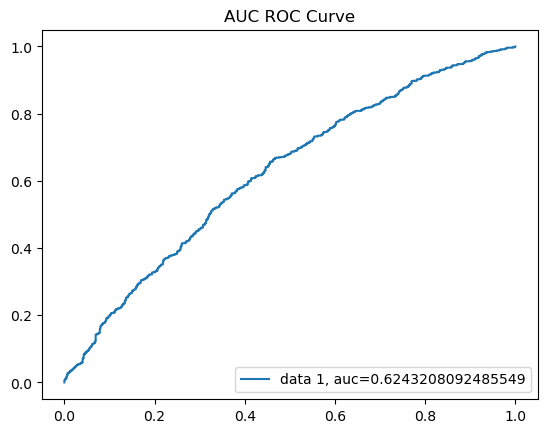

In [250]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_pred_proba =model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title("AUC ROC Curve")
plt.show()

In [251]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution
param_dist = {"n_estimators": randint(10, 100),
              "max_depth": randint(1, 10),
              "min_samples_split": randint(2, 10),
              "min_samples_leaf": randint(1, 10)}

# Instantiate the random forest classifier
rf = RandomForestClassifier()

# Instantiate the randomized search
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=100, cv=5, random_state=42)

# Fit the randomized search on the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print(random_search.best_score_)
print(random_search.best_params_)

0.6069992902957994
{'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 9, 'n_estimators': 91}


In [67]:
fighter1 = "Nate Diaz"
fighter2 = "Conor McGregor"

In [42]:
df_fighters.loc[:,'pct_of_control_fighter'] = df_fighters['CTRL_fighter']/df_fighters['TotalTime']
df_fighters.loc[:,'strikes_fighter_f'] = (df_fighters['SIG.STR._landed_fighter']/df_fighters['TotalTime'])*60


In [57]:
df_fighters[['form_skore_fighter','pct_of_control_fighter', 'strikes_fighter_f']] = scaler.fit_transform(df_fighters[['form_skore_fighter','pct_of_control_fighter', 'strikes_fighter_f']])

In [68]:
f1 = df_fighters.loc[df_fighters["FIGHTER"]==fighter1 ,['form_skore_fighter','pct_of_control_fighter', 'strikes_fighter_f']].values.flatten().tolist()

In [69]:
f2 = df_fighters.loc[df_fighters["FIGHTER"]==fighter2 ,['form_skore_fighter','pct_of_control_fighter', 'strikes_fighter_f']].values.flatten().tolist()

In [70]:
f1+f2

[0.39875325803342343,
 -0.45128862367049577,
 0.8860974239040257,
 -0.45686035044738443,
 -0.5655206746811349,
 1.4218252543277097]

In [71]:
predikce = model.predict([f1+f2])
predikce[0][0]

1/1 [==============================] - 0s 45ms/step


0.5540724

In [72]:
print(f"{fighter1}: {round(predikce[0][0]*100,2)}%  vs {fighter2}: {round((1-predikce[0][0])*100,2)}")

Nate Diaz: 55.41%  vs Conor McGregor: 44.59


In [73]:
'McGr' in df_fighters['FIGHTER'].tolist()

False